In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import scale

from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.layers.normalization import BatchNormalization
from keras.initializers import Initializer
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


Using TensorFlow backend.


In [52]:
raw_data = pd.read_csv('./data/ordered_molecules.csv')

In [53]:
#x_data = raw_data.loc[(raw_data['time'] >= 0) & (raw_data['time'] <= 1998)]
#target_data = raw_data.loc[(raw_data['time'] >= 1) & (raw_data['time'] <= 1999)]

x_data = raw_data.loc[(raw_data['time'] >= 0) & (raw_data['time'] <= 1989)]
target_data = raw_data.loc[(raw_data['time'] >= 10) & (raw_data['time'] <= 1999)]


In [54]:
data = pd.concat([x_data.reset_index(drop=True), target_data.iloc[:,2:].reset_index(drop=True)], axis = 1, ignore_index=True)

In [55]:
data.columns = ['time','molecule','px','py','pz','ax','ay','az','px_next','py_next','pz_next','ax_next','ay_next','az_next']

In [56]:
data['del_px'] = data['px_next'] - data['px']
data['del_py'] = data['py_next'] - data['py']
data['del_pz'] = data['pz_next'] - data['pz']

In [57]:
final_data = data.drop(columns =['px','py','pz','px_next','py_next','pz_next'])

In [58]:
final_data = final_data[['time','molecule','ax','ay','az','del_px','del_py','del_pz','ax_next','ay_next','az_next']] #컬럼순서 변경

In [59]:
final_data.tail()

,time,molecule,ax,ay,az,del_px,del_py,del_pz,ax_next,ay_next,az_next
254715,1989,124,-1.679005,3.955862,-1.420777,-0.06377,0.02734,0.03183,-1.025038,3.645025,-1.280867
254716,1989,125,2.515733,-3.602815,-0.837633,-0.04544,0.03246,0.06656,3.634594,-3.766582,-2.338953
254717,1989,126,-1.451675,6.201034,5.922080,-0.00429,0.02273,0.01322,2.307742,5.650190,5.404642
254718,1989,127,3.319556,0.500349,-2.324341,0.00913,0.09224,-0.06820,1.395564,-1.232665,-0.779073
254719,1989,128,0.500217,-1.307963,0.760103,0.07000,0.07214,0.10875,-0.730089,-1.992210,-0.056095


In [60]:
test_df = final_data.loc[abs(final_data['del_px']) <12]



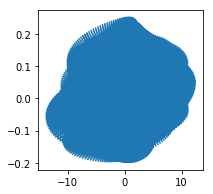

In [61]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax1.plot(test_df['ax'], test_df['del_px'])
#ax1.set_ylim((-5,5))

In [10]:
'''
def revise_position(x):
    more_than_12, = np.where(x > 12)
    less_than_minus_12, = np.where(x < -12)
    
    new_more_values = x[more_than_12] - 12.9168567587204
    new_less_values = x[less_than_minus_12] + 12.9168567587204
    
    y = x.copy()
    
    y.loc[more_than_12] = new_more_values
    y.loc[less_than_minus_12] = new_less_values
    
    return(y)
'''

#final_data['del_px'] = revise_position(final_data['del_px'])
#final_data['del_py'] = revise_position(final_data['del_py'])
#final_data['del_pz'] = revise_position(final_data['del_pz'])

'\ndef revise_position(x):\n    more_than_12, = np.where(x > 12)\n    less_than_minus_12, = np.where(x < -12)\n    \n    new_more_values = x[more_than_12] - 12.9168567587204\n    new_less_values = x[less_than_minus_12] + 12.9168567587204\n    \n    y = x.copy()\n    \n    y.loc[more_than_12] = new_more_values\n    y.loc[less_than_minus_12] = new_less_values\n    \n    return(y)\n'

In [11]:
x_train = final_data.loc[(final_data['time'] >= 0) & (final_data['time'] <= 1399)].iloc[:,2:5]
y_train = final_data.loc[(final_data['time'] >= 0) & (final_data['time'] <= 1399)].iloc[:,5:]

In [12]:
exc_x_idx, = np.where(abs(y_train['del_px']) > 12)
exc_y_idx, = np.where(abs(y_train['del_py']) > 12)
exc_z_idx, = np.where(abs(y_train['del_pz']) > 12)

exc_idx = set(exc_x_idx) | set(exc_y_idx) | set(exc_z_idx)

x_train = x_train.loc[x_train.index.drop(list(exc_idx))].reset_index(drop=True)
y_train = y_train.loc[y_train.index.drop(list(exc_idx))].reset_index(drop=True)

In [28]:
x_train.head()

,ax,ay,az
0,1.185458,-1.527830,-4.614324
1,-4.601109,-0.659241,1.090967
2,4.530882,-2.598597,2.008448
3,3.975239,0.917088,-2.261618
4,-1.861295,-0.908830,5.337542


In [13]:
x_test = final_data.loc[(final_data['time'] >= 1400) & (final_data['time'] <= 1998)].iloc[:,2:5]
y_test = final_data.loc[(final_data['time'] >= 1400) & (final_data['time'] <= 1998)].iloc[:,5:]

In [14]:
#model 1
model_1 = Sequential()

model_1.add(Dense(32, input_dim=3, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(Dense(32, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(Dense(32, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(Dense(6, activation='linear', kernel_initializer = 'glorot_normal', kernel_regularizer = regularizers.l2(0.01)))

In [727]:
model_1.compile(loss='mean_squared_error', optimizer= "rmsprop", metrics=['mse'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, mode='min')
model_check_point = ModelCheckpoint('./model/DNN_Only_position.h5', monitor = 'val_loss', verbose=2, save_best_only=True)
callback_list = [model_check_point, early_stop]

In [728]:
hist_1 = model_1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=150, batch_size=64, callbacks = callback_list)

Train on 178964 samples, validate on 76581 samples
Epoch 1/150
178964/178964 [==============================] - 6s 35us/step - loss: 0.4231 - mean_squared_error: 0.0628 - val_loss: 0.2249 - val_mean_squared_error: 0.0198

Epoch 00001: val_loss improved from inf to 0.22489, saving model to ./model/DNN_Only_position.h5
Epoch 2/150
178964/178964 [==============================] - 6s 31us/step - loss: 0.2171 - mean_squared_error: 0.0158 - val_loss: 0.2117 - val_mean_squared_error: 0.0134

Epoch 00002: val_loss improved from 0.22489 to 0.21172, saving model to ./model/DNN_Only_position.h5
Epoch 3/150
178964/178964 [==============================] - 6s 31us/step - loss: 0.2116 - mean_squared_error: 0.0164 - val_loss: 0.2089 - val_mean_squared_error: 0.0167

Epoch 00003: val_loss improved from 0.21172 to 0.20887, saving model to ./model/DNN_Only_position.h5
Epoch 4/150
178964/178964 [==============================] - 6s 31us/step - loss: 0.2073 - mean_squared_error: 0.0174 - val_loss: 0.2020 

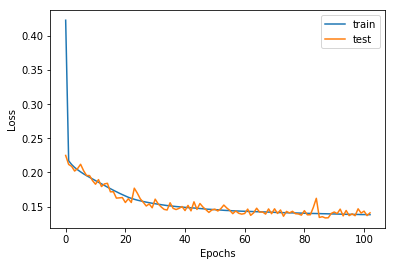

In [729]:
# plot history
plt.plot(hist_1.history['loss'], label='train')
plt.plot(hist_1.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
model = load_model('./model/DNN_Only_position.h5')

In [16]:
y_pred_train = pd.DataFrame(model.predict(x_train))

print('rmse:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('mae:', mean_absolute_error(y_train, y_pred_train))
print('r2:', r2_score(y_train, y_pred_train))

rmse: 0.10389751681762525
mae: 0.06236633453161825
r2: -9.528559869759592


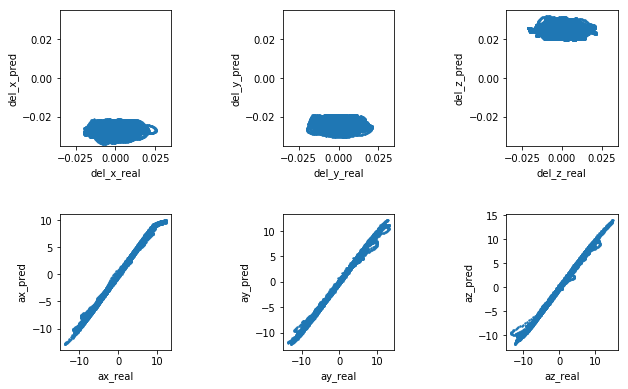

In [25]:
#Training error Check
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)

ax1.scatter(y_train['del_px'], y_pred_train.iloc[:,0], s=2)
ax1.set_xlabel('del_x_real')
ax1.set_ylabel('del_x_pred')
ax1.set_xlim((-0.035, 0.035))
ax1.set_ylim((-0.035, 0.035))

ax2.scatter(y_train['del_py'], y_pred_train.iloc[:,1], s=2)
ax2.set_xlabel('del_y_real')
ax2.set_ylabel('del_y_pred')
ax2.set_xlim((-0.035, 0.035))
ax2.set_ylim((-0.035, 0.035))

ax3.scatter(y_train['del_pz'], y_pred_train.iloc[:,2], s=2)
ax3.set_xlabel('del_z_real')
ax3.set_ylabel('del_z_pred')
ax3.set_xlim((-0.035, 0.035))
ax3.set_ylim((-0.035, 0.035))

ax4.scatter(y_train['ax_next'], y_pred_train.iloc[:,3], s=2)
ax4.set_xlabel('ax_real')
ax4.set_ylabel('ax_pred')

ax5.scatter(y_train['ay_next'], y_pred_train.iloc[:,4], s=2)
ax5.set_xlabel('ay_real')
ax5.set_ylabel('ay_pred')

ax6.scatter(y_train['az_next'], y_pred_train.iloc[:,5], s=2)
ax6.set_xlabel('az_real')
ax6.set_ylabel('az_pred')

plt.subplots_adjust(wspace = 1, hspace = 0.5)
plt.show()

In [18]:
#Test error Check
y_pred = pd.DataFrame(model.predict(x_test))

In [23]:
now_data = raw_data.loc[(raw_data['time'] >= 1400) & (raw_data['time'] <= 1998)].reset_index(drop=True)
next_data = raw_data.loc[(raw_data['time'] >= 1401) & (raw_data['time'] <= 1999)].reset_index(drop=True)

next_position = pd.DataFrame(np.array(now_data[['px','py','pz']]) + np.array(y_pred.iloc[:,0:3]), columns=['px_pred','py_pred','pz_pred'])

predicted_df = pd.concat([next_position, y_pred.iloc[:,3:]], axis = 1)

exc_x_idx_test, = np.where(abs(next_data['px'] - predicted_df['px_pred']) > 12)
exc_y_idx_test, = np.where(abs(next_data['py'] - predicted_df['py_pred']) > 12)
exc_z_idx_test, = np.where(abs(next_data['pz'] - predicted_df['pz_pred']) > 12)

exc_idx_test = set(exc_x_idx_test) | set(exc_y_idx_test) | set(exc_z_idx_test)

next_data = next_data.loc[next_data.index.drop(list(exc_idx_test))].reset_index(drop=True)
predicted_df = predicted_df.loc[predicted_df.index.drop(list(exc_idx_test))].reset_index(drop=True)

print('rmse:', np.sqrt(mean_squared_error(next_data.iloc[:,2:5], predicted_df.iloc[:,0:3])))
print('mae:', mean_absolute_error(next_data.iloc[:,2:5], predicted_df.iloc[:,0:3]))
print('r2:', r2_score(next_data.iloc[:,2:5], predicted_df.iloc[:,0:3]))

rmse: 0.025713860508683992
mae: 0.02503448855981506
r2: 0.9999526911682434


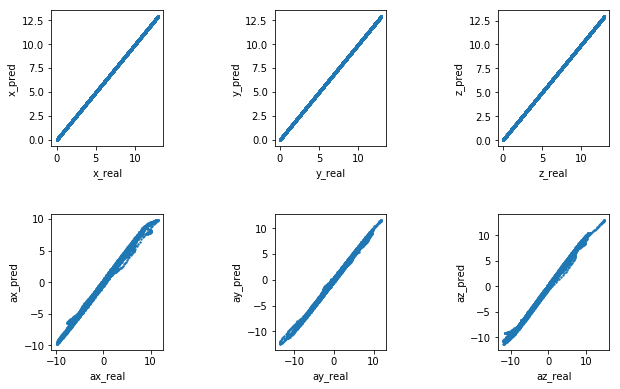

In [22]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)

ax1.scatter(next_data['px'], predicted_df.iloc[:,0], s= 2)
ax1.set_xlabel('x_real')
ax1.set_ylabel('x_pred')


ax2.scatter(next_data['py'], predicted_df.iloc[:,1], s= 2)
ax2.set_xlabel('y_real')
ax2.set_ylabel('y_pred')


ax3.scatter(next_data['pz'], predicted_df.iloc[:,2], s= 2)
ax3.set_xlabel('z_real')
ax3.set_ylabel('z_pred')


ax4.scatter(next_data['ax'], predicted_df.iloc[:,3], s= 2)
ax4.set_xlabel('ax_real')
ax4.set_ylabel('ax_pred')
ax5.scatter(next_data['ay'], predicted_df.iloc[:,4], s= 2)
ax5.set_xlabel('ay_real')
ax5.set_ylabel('ay_pred')
ax6.scatter(next_data['az'], predicted_df.iloc[:,5], s= 2)
ax6.set_xlabel('az_real')
ax6.set_ylabel('az_pred')

plt.subplots_adjust(wspace = 1, hspace = 0.5)
plt.show()